In [21]:
#4个部分 
#1输入部分，2编码器实现，3解码器实现，4输出部分
#最终构建模型

embr: tensor([[[-6.4166e+00,  1.3479e+01, -1.4113e+01,  ...,  5.5647e+01,
           3.4186e+01,  1.5448e+01],
         [ 2.6692e+01, -3.8826e+01,  4.3667e+01,  ..., -2.1341e+01,
           6.3210e-01, -2.1216e+01],
         [-5.1631e+00, -1.5114e+01, -4.1016e+01,  ..., -2.5120e+01,
           2.2468e+01, -4.4861e+00],
         [-3.1380e+01, -6.3652e+00, -2.1012e+00,  ..., -5.0712e+01,
           2.4083e+01, -6.5295e+00]],

        [[-4.1235e+00, -3.9298e+01, -7.9299e+00,  ...,  2.4807e+01,
          -4.4432e+00, -1.7915e+00],
         [-7.4438e-01, -7.4850e+00, -1.5728e+01,  ..., -4.2814e+01,
           1.7602e+01, -3.3869e+01],
         [ 8.1172e+00,  1.1260e+01, -8.6543e+00,  ..., -1.7889e+01,
          -7.5308e+00, -3.6418e+01],
         [-1.6937e+00,  1.5326e+00,  1.3025e+01,  ..., -2.4720e+01,
          -9.9317e+00, -3.4635e-02]]], grad_fn=<MulBackward0>)
pe_result: tensor([[[ -8.0208,   0.0000, -17.6411,  ...,  70.8085,  42.7320,   0.0000],
         [  0.0000, -47.8576,   0.0000

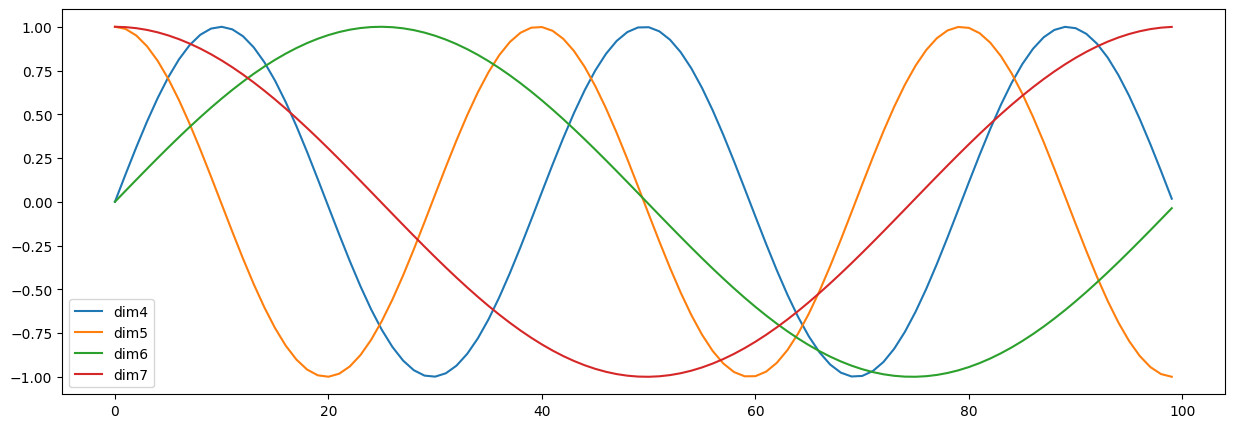

In [22]:
#1.输入部分实现
# 输入部分包含:
# 源文本嵌入层及其位置编码器
# 目标文本嵌入层及其位置编码器
import torch 
import torch.nn as nn 
import math
from torch.autograd import  Variable

# 1.1嵌入层
class Embeddings(nn.Module): 
    def __init__(self,vocab,dim_model,):
        """类的初始化函数, 有两个参数, vocab: 指词表的大小.dim_model: 指词嵌入的维度, """
        super(Embeddings,self).__init__()
        #定义embeding层
        # 调用nn中的预定义层Embedding, 获得一个词嵌入对象self.lut （是否多余）
        self.lut=nn.Embedding(vocab,dim_model)
        self.dim_model=dim_model

    def forward(self,x):
        return self.lut(x) *math.sqrt(self.dim_model) 
# 词嵌入维度是512维
d_model = 512
# 词表大小是1000
vocab = 1000
x=Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb=Embeddings(vocab=vocab,dim_model=d_model)
embr = emb(x)
print("embr:", embr) #2*4*512


# 1.2定义位置编码器类, 我们同样把它看做一个层, 因此会继承nn.Module
class PositionalEncoding(nn.Module):
    def __init__(self,dim_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(p=dropout)

        #初始化一个位置编码矩阵，矩阵大小是 max_len*dim_model 例如5000行3列
        pe=torch.zeros(max_len,dim_model)
        #初始化一个绝对位置矩阵，词汇的绝对位置就是它的索引表示
        # unsqueeze(1) 表示 max_len*1   # 5000*1
        position=torch.arange(0,max_len).unsqueeze(1) #5000->5000*1
        
        #绝对位置矩阵初始化后 如何将信息添加到位置编码矩阵呢 那就是制造1*model 变换矩阵
        #5000*1 *  1*3 -> 5000*3
        div_term=torch.exp(torch.arange(0,dim_model,2) * -(math.log(10000.0)/dim_model))
        # 并把这两个矩阵(pos*v)分别填充在位置编码矩阵的偶数和奇数位置上，组成最终的位置编码矩阵.
        pe[:,0::2]=torch.sin(position *div_term)
        pe[:,1::2]=torch.cos(position *div_term)
        # pe现在还只是一个二维矩阵，要想和embedding的输出（一个三维张量）相加，
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度.
        pe=pe.unsqueeze(0)
        #将位置编码矩阵注册成模型的buffer，不是模型超参数，不会随着优化改变
        self.register_buffer('pe',pe)
    
    def forward(self,x):
        #1*5000*3太长了， 需要将max_len缩小成与x同等的长度 ->1*X(第二个参数)*3
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x) #依次输出 x第二个参数（行）*(维度) #1*4*512  

d_model=512
p=0.2
max_len=60
x=embr #输入x,是Embedding层的输出result的张量, 形状是2 x 4 x 512
pe=PositionalEncoding(d_model,p,max_len)
pe_result = pe(x)
print("pe_result:", pe_result)
print("pe_result的形状", pe_result.shape)

#1.3 绘制词汇向量中特征的分布曲线
import matplotlib.pyplot as plt
import numpy as np
#创建画布
plt.figure(figsize=(15,5))
pe=PositionalEncoding(20,0) #词嵌入维度dim_model=20,p=0
# 然后向pe传入被Variable封装的tensor, 这样pe会直接执行forward函数, 
# 且这个tensor里的数值都是0, 被处理后相当于位置编码张量
y=pe(Variable(torch.zeros(1,100,20)))
plt.plot(np.arange(100),y[0,:,4:8].data.numpy()) #20维度之查看4567维度
plt.legend(["dim%d"%p for p in [4,5,6,7]])

In [31]:
# 2.编码器实现
# 编码器部分:
# 由N个编码器层堆叠而成
# 每个编码器层由两个子层连接结构组成
# 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
# 第二个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接
import torch.nn.functional as F
# 2.1掩码张量
# np.triu()#主对角线的右上三角 k=0
def subsequent_mask(size):
    #size 掩码张量后的最后两个维度，形成一个方针
    attn_shape=(1,size,size)
    #构建上三角矩阵
    subsequent_mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')#8节约空间
    return torch.from_numpy(1-subsequent_mask)#进行三角反转 每个元素会被1减掉
# size=5
# sm=subsequent_mask(size)
# print('sm',sm)
# 掩码张量的可视化:
# plt.figure(figsize=(5,5))
# plt.imshow(subsequent_mask(20)[0])
# 因此，未来的信息可能被提前利用. 所以，我们会进行遮掩. 注意力机制向后学习

# 2.2 注意力机制
def attention(query,key,value,mask=None,dropout=None): #根据query和key得到value ，多次query和key得到value更新
    #取q的最后一个维度dim_model词嵌入维度d_k
    d_k=query.size(-1)#就是之前dim_model
    #求得注意力分数 query和key相乘的话  n*m *m*k 至少m是相同的，我们把这个m看成dim_model
    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)# query最后的dim_model和转换后的kye的dim_model相乘，结果缩放
    #判断掩码张量
    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9) #如果是0标记为需要被遮掩 设置为较小数
    #为了和value求得，并且获取注意力张量
    p_atten=F.softmax(scores,dim=-1)

    if dropout is not None:
        p_atten=dropout(p_atten)
    return torch.matmul(p_atten,value),p_atten

# query=key=value=pe_result
# mask=Variable(torch.zeros(2,4,4))
# attn,p_atten=attention(query,key,value,mask=mask)
# print('attn',attn)
# print('atten的shape',attn.shape)
# print('p_attn,注意力张量矩阵',p_atten)
# print('p_attn的shape',p_atten.shape)

# 2.3多头注意力机制  {编码器的第一部分}
#比如4头注意力机制，就是将512的词嵌入维度 变成512/4 *4 每个128都将进行一个qkv，最后拼接进入线性层
import copy
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])#深拷贝n个module 加载到modulelist

class MultiHeadAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        super(MultiHeadAttention,self).__init__()

        assert embedding_dim%head==0 #判断512是否被4整除 假设dim_model是512 分4头注意力
        self.d_k=embedding_dim//head #512//4=128 
        self.head=head #4

        # 然后获得线性层对象，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim x embedding_dim，然后使用clones函数克隆四个，
        # 为什么是四个呢，这是因为在多头注意力中，Q，K，V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个.
        self.linears=clones(nn.Linear(embedding_dim,embedding_dim),4) #方阵
        
        self.attn=None
        self.dropout=nn.Dropout(p=dropout)

    def forward(self,query,key,value,mask=None):
        if mask is not None:
            mask=mask.unsqueeze(0) #拓展维度 代表多头中的第几个头  torch.Size([1, 4, 4, 4])

        batch_size=query.size(0) #代表多少条样本
        # print(batch_size)  2
        query,key,value= [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2) \
            #变成形状为(batch_size, head, seq_len, d_k)的四维张量
            #将head数和view-1后的词长度（seq_len）与词维度(d_k)靠近，更适合注意力机制的训练
            for model,x in zip(self.linears,(query,key,value))] 
            #linears中的有4个linear，x是3个参数，通过zip匹配打包model和x，依次命名为q(model,x),k(model,x),v(model,x)
            # （linears最后一个线性层是结果输出，没有匹配就不进来）
        #-1等于 #2*4*512->[2, 4, 4, 128] {-1为4}
        # print(query.shape,key.shape,value.shape)   torch.Size([2, 4, 4, 128])
        
        #得到每个头中qkv经过linear的输出后，进入到attention机制求得输出
        x,self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
        #(batch_size, head, seq_len, d_k)的四维张量恢复 x=x.transpose(1,2) ->(batch_size,seq_len,head,d_k)
        #如果先transpose的话再view会报错 需要进行contiguous 
        x=x.transpose(1,2).contiguous().view(batch_size,-1,self.head*self.d_k)#2*-1*4*128
        # print('x',x.shape)x torch.Size([2, 4, 512])
        return self.linears[-1](x)#最后一个 x进入第4个linear进行输出

# #实例化若干参数
# head=4
# embedding_dim=512
# dropout=0.1
# #若干参数的初始化
# key=value=query=pe_result #2*4*512
# mask=Variable(torch.zeros(4,4,4))
# mha=MultiHeadAttention(head,embedding_dim,dropout)
# mha_result=mha(query,key,value,mask)
# print('multi_head_result:',mha_result)
# print('multi_ead_result的形状',mha_result.shape)



# 2.4 前馈全连接层 {编码器的第二部分}
# 前馈全连接层的作用:
# 考虑注意力机制可能对复杂过程的拟合程度不够, 通过增加两层网络来增强模型的能力.
# 在Transformer中前馈全连接层就是具有两层线性层的全连接网络.
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        #d_model第一个是线性层的输入维度也是第二个线性层的输出维度，
        #d_ff第一个是线性层的输出维度也是第二个线性层的输入维度，
        super(PositionwiseFeedForward,self).__init__()
        self.w1=nn.Linear(d_model,d_ff)        
        self.w2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x):
        return self.w2(self.dropout(F.relu(self.w1(x))))        

# d_model = 512
# # 线性变化的维度
# d_ff = 64
# dropout = 0.2
# x=mha_result

# ff=PositionwiseFeedForward(d_model,d_ff,dropout)
# ff_result=ff(x)
# print('ff_result',ff_result)
# print('ff_result的形状',ff_result.shape)




# 2.5 规范化层
# 规范化层的作用:
# 它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，
# 通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，
# 模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内.

class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        #features 词嵌入温度。 eps防止分母为0  一个足够小的正数
        super(LayerNorm,self).__init__()
        #初始化2个参数张量 a2 b2 用于对结果做规划化操作计算
        # 将其用nn.parameter封装，代表也是模型中的参数
        self.a2=nn.Parameter(torch.ones(features))       
        self.b2=nn.Parameter(torch.zeros(features))       
        self.eps=eps
    
    def forward(self,x):
        #x:上一层网络的输出
        #首先对x进行最后一个维度的均值，并保持输入输出维度一致
        mean=x.mean(-1,keepdim=True)
        #对x进行最后一个维度的标准差，并保持
        std=x.std(-1,keepdim=True)
        #按照规划化公式
        return self.a2*(x-mean)/(std+self.eps)+self.b2

# features = d_model = 512
# eps = 1e-6
# ln = LayerNorm(features, eps)
# ln_result = ln(x)
# print('ln_result:',ln_result)
# print('ln_result的形状',ln_result.shape)

# 2.6 子层连接结构
# 输入到每个子层以及规范化层的过程中，还使用了残差链接（跳跃连接），
# 因此我们把这一部分结构整体叫做子层连接（代表子层及其链接结构），
# 在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.

class SublayerConnection(nn.Module):
    def __init__(self,size,dropout=0.1):  #size 词嵌入维度
        super(SublayerConnection,self).__init__()
        self.norm=LayerNorm(size)
        self.dropout=nn.Dropout(dropout)
    
    def forward(self,x,sublayer):
        # 因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出.
        #x：上一层传入张量， sublayer子层连接中子层函数（到底是多头注意力层还是前馈层）
        return x+self.dropout(sublayer(self.norm(x)))
# size = 512
# dropout = 0.2
# head = 4
# d_model = 512
# # 令x为位置编码器的输出
# x = pe_result
# mask = Variable(torch.zeros(4, 4, 4))
# # 假设子层中装的是多头注意力层, 实例化这个类 xxx自注意力机制
# self_attn = MultiHeadAttention(head, d_model)
# # 使用lambda获得一个函数类型的子层
# sublayer = lambda x: self_attn(x, x, x, mask)
# sc = SublayerConnection(size, dropout)
# sc_result = sc(x, sublayer)
# print('sc_result',sc_result)
# print('sc_result的形状',sc_result.shape)


# 2.7 编码器层
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):#size 词嵌入维度
        super().__init__()
        self.self_attn=self_attn
        self.feed_forward=feed_forward

        self.sublayer=clones(SublayerConnection(size,dropout),2)
        self.size=size

    def forward(self,x,mask):
        #x:上一层的输出
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)

# size = 512
# head = 4
# d_model = 512
# d_ff = 64
# x = pe_result
# dropout = 0.2
# self_attn = MultiHeadAttention(head, d_model)
# ff = PositionwiseFeedForward(d_model, d_ff, dropout)
# mask = Variable(torch.zeros(4, 4, 4))
# el = EncoderLayer(size, self_attn, ff, dropout)
# el_result = el(x, mask)
# print(el_result)
# print(el_result.shape)


#2.8编码器（包含n个编码器层）
# 使用Encoder类来实现编码器
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

# 第一个实例化参数layer, 它是一个编码器层的实例化对象, 因此需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.
size = 512
head = 8
d_model = 512
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = EncoderLayer(size, c(attn), c(ff), dropout)
# 编码器中编码器层的个数N
N = 8
mask = Variable(torch.zeros(8, 4, 4))
en=Encoder(layer,N)
en_result=en(x,mask)
print('en_result',en_result)
print('en_result的形状',en_result.shape)

en_result tensor([[[-2.7593, -1.5365, -0.9799,  ...,  1.6932,  2.2750,  0.2866],
         [-1.5937, -2.0826, -0.4490,  ...,  0.0293,  1.3043, -0.5968],
         [-2.0969, -1.9216,  0.0159,  ...,  1.5079,  2.2313, -1.3760],
         [-2.4813, -2.3479, -1.0651,  ..., -0.5948,  1.5771, -0.1111]],

        [[-0.5347, -0.8207,  0.2075,  ...,  0.7135, -0.9284,  0.0612],
         [-0.9031, -0.5403, -0.5091,  ..., -0.1502, -1.2164, -0.3560],
         [-1.3402,  0.1047,  0.7625,  ...,  0.7145, -0.2092, -0.7473],
         [-0.5076,  0.1761, -0.1672,  ...,  0.0478, -0.0445,  0.7279]]],
       grad_fn=<AddBackward0>)
en_result的形状 torch.Size([2, 4, 512])


In [32]:
# 3.解码器的实现
# 3.1 解码器层的实现
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()
        self.size=size
        self.self_attn=self_attn#自注意力层
        self.src_attn=src_attn#Q！K=v 多头注意力对象
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),3)# 有3个跳跃连接 （残差链接

    def forward(self,x,memory,source_mask,target_mask):
        m=memory#编码器的输出
        
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,target_mask)) #对未来数据进行遮掩，因为此时模型还没有生成任何目标数据

        x=self.sublayer[1](x,lambda x:self.src_attn(x,m,m,source_mask))#q是输入x; k，v是编码层输出memory//遮蔽掉对结果没有意义的字符而产生的注意力值
 
        return self.sublayer[2](x,self.feed_forward)

# # 类的实例化参数与解码器层类似, 相比多出了src_attn, 但是和self_attn是同一个类.
# head = 4
# size = 512
# d_model = 512
# d_ff = 64
# dropout = 0.2
# self_attn = src_attn = MultiHeadAttention(head, d_model, dropout)

# # 前馈全连接层也和之前相同 
# ff = PositionwiseFeedForward(d_model, d_ff, dropout)
# x=pe_result
# memory=en_result
# mask=Variable(torch.zeros(4,4,4))
# source_mask=target_mask=mask

# dl=DecoderLayer(size,self_attn,src_attn,ff,dropout)
# dl_result=dl(x,memory,source_mask,target_mask)
# print(dl_result)

#3.2 解码器实现 
# 根据编码器的结果以及上一次预测的结果, 对下一次可能出现的'值'进行特征表示.

class Decoder(nn.Module):
    def __init__(self,layer,N):
        super(Decoder,self).__init__()

        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
        
    def forward(self,x,memory,source_mask,target_mask):
        for layer in self.layers:
            x=layer(x,memory,source_mask,target_mask)
        return self.norm(x)

size=512
d_model=512
head=8
d_ff=64
dropout=0.2
c=copy.deepcopy
attn=MultiHeadAttention(head,d_model)
ff=PositionwiseFeedForward(d_model,d_ff,dropout)
layer=DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout)
N=8
x=pe_result
memory=en_result
mask=source_mask=target_mask=Variable(torch.zeros(8,4,4))
de=Decoder(layer,N)
de_result=de(x,memory,source_mask,target_mask)
print(de_result)


tensor([[[-0.4727,  0.1611, -0.6883,  ...,  2.7033,  1.5645, -0.1977],
         [-0.0073, -1.6776,  0.0619,  ..., -0.7581, -0.0431, -0.1571],
         [-0.2578, -0.7272, -0.0637,  ..., -0.0632,  1.0259, -0.4604],
         [-1.5870, -0.1653, -0.2183,  ..., -2.3228,  1.0428, -0.4061]],

        [[ 0.0747, -1.7959, -0.3735,  ...,  1.5047,  0.0673,  0.0963],
         [ 0.0225, -0.3825, -0.6687,  ..., -1.8557,  0.9986, -1.4226],
         [ 0.4447,  0.5382, -0.0289,  ..., -0.6162, -0.2934, -1.6982],
         [-0.0457,  0.0711,  0.7535,  ..., -1.1183,  0.1869, -0.0033]]],
       grad_fn=<AddBackward0>)


In [33]:
# 4,输出部分的实现
# 线性层的作用：通过对上一步的线性变化得到指定维度的输出, 也就是转换维度的作用.
# softmax层的作用：使最后一维的向量中的数字缩放到0-1的概率值域内, 并满足他们的和为1.

class Generator(nn.Module):
    def __init__(self,d_model,vocab_size):
        super(Generator,self).__init__()
        self.project=nn.Linear(d_model,vocab_size) #网络输出维度的线性变化 2,4,512->2,4,1000

    def forward(self,x):
        return F.log_softmax(self.project(x),dim=-1)

d_model=512
vocab_size=1000
x=de_result
gen=Generator(d_model,vocab_size)
gen_result=gen(de_result)
print(gen_result.shape)

torch.Size([2, 4, 1000])


In [ ]:
#最终构建模型
# 编码器-解码器结构的代码实现
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,source_embed,target_embed,generator):
        #编码器对象，解码器对象，源数据嵌入函数，目标数据嵌入函数，输出部分的类别生成器对象
        super(EncoderDecoder,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=source_embed
        self.tgt_embed=target_embed
        self.generator=generator

    def encode(self,source,source_mask):
        return self.encoder(self.src_embed(source),source_mask)
    def decode(self,memory,source_mask,target,target_mask):
        return self.decoder(self.tgt_embed(target),memory,source_mask,target_mask)

    def forward(self,source,target,source_mask,target_mask):
        #源数据，目标数据，源目标掩码矩阵，目标掩码矩阵
        return self.decoder(self.encode(source,source_mask),source_mask,target,target_mask)
    
# vocab_size=1000
# d_model=512
# encoder=en
# decoder=de
# source_embed=nn.Embedding(vocab_size,d_model)
# target_embed=nn.Embedding(vocab_size,d_model)
# generator=gen
# # 假设源数据与目标数据相同, 实际中并不相同
# source = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
# # 假设src_mask与tgt_mask相同，实际中并不相同
# source_mask = target_mask = Variable(torch.zeros(8, 4, 4))
# ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
# ed_result = ed(source, target, source_mask, target_mask)
# print(ed_result)
# print(ed_result.shape)


In [38]:
# Tansformer模型构建过程的代码分析
def make_model(source_vocab,target_vocab,N=6,d_model=512,d_ff=2048,head=8,dropout=0.1):
    c=copy.deepcopy
    attn=MultiHeadAttention(head,d_model)
    ff=PositionwiseFeedForward(d_model,d_ff,dropout)
    position=PositionalEncoding(d_model,dropout)

    model=EncoderDecoder(
        Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
        nn.Sequential(Embeddings(d_model,source_vocab),c(position)),
        nn.Sequential(Embeddings(d_model,target_vocab),c(position)),
        Generator(d_model,target_vocab)
    )

    for p in model.parameters():
        if p.dim()>1:# 这里一但判断参数的维度大于1，则会将其初始化成一个服从均匀分布的矩阵，
            nn.init.xavier_uniform(p)
    return model

source_vocab=11
target_vocab=11
N=6
if __name__=='__main__':
    res=make_model(source_vocab,target_vocab,N)
    print(res)

/home/ysy/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [ ]:
# 使用copy任务进行模型基本测试的四步曲
# 第一步: 构建数据集生成器
# 第二步: 获得Transformer模型及其优化器和损失函数
# 第三步: 运行模型进行训练和评估
# 第四步: 使用模型进行贪婪解码


In [ ]:
# 使用Transformer构建语言模型

#1导入必备工具包
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext.data.utils import get_tokenizer
# 已经构建完成的TransformerModel
from pyitcast.transformer import TransformerModel